In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import bpdev as bd
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency


from Bio import AlignIO
import time as time
import pandas as pd
np.random.seed(42)

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


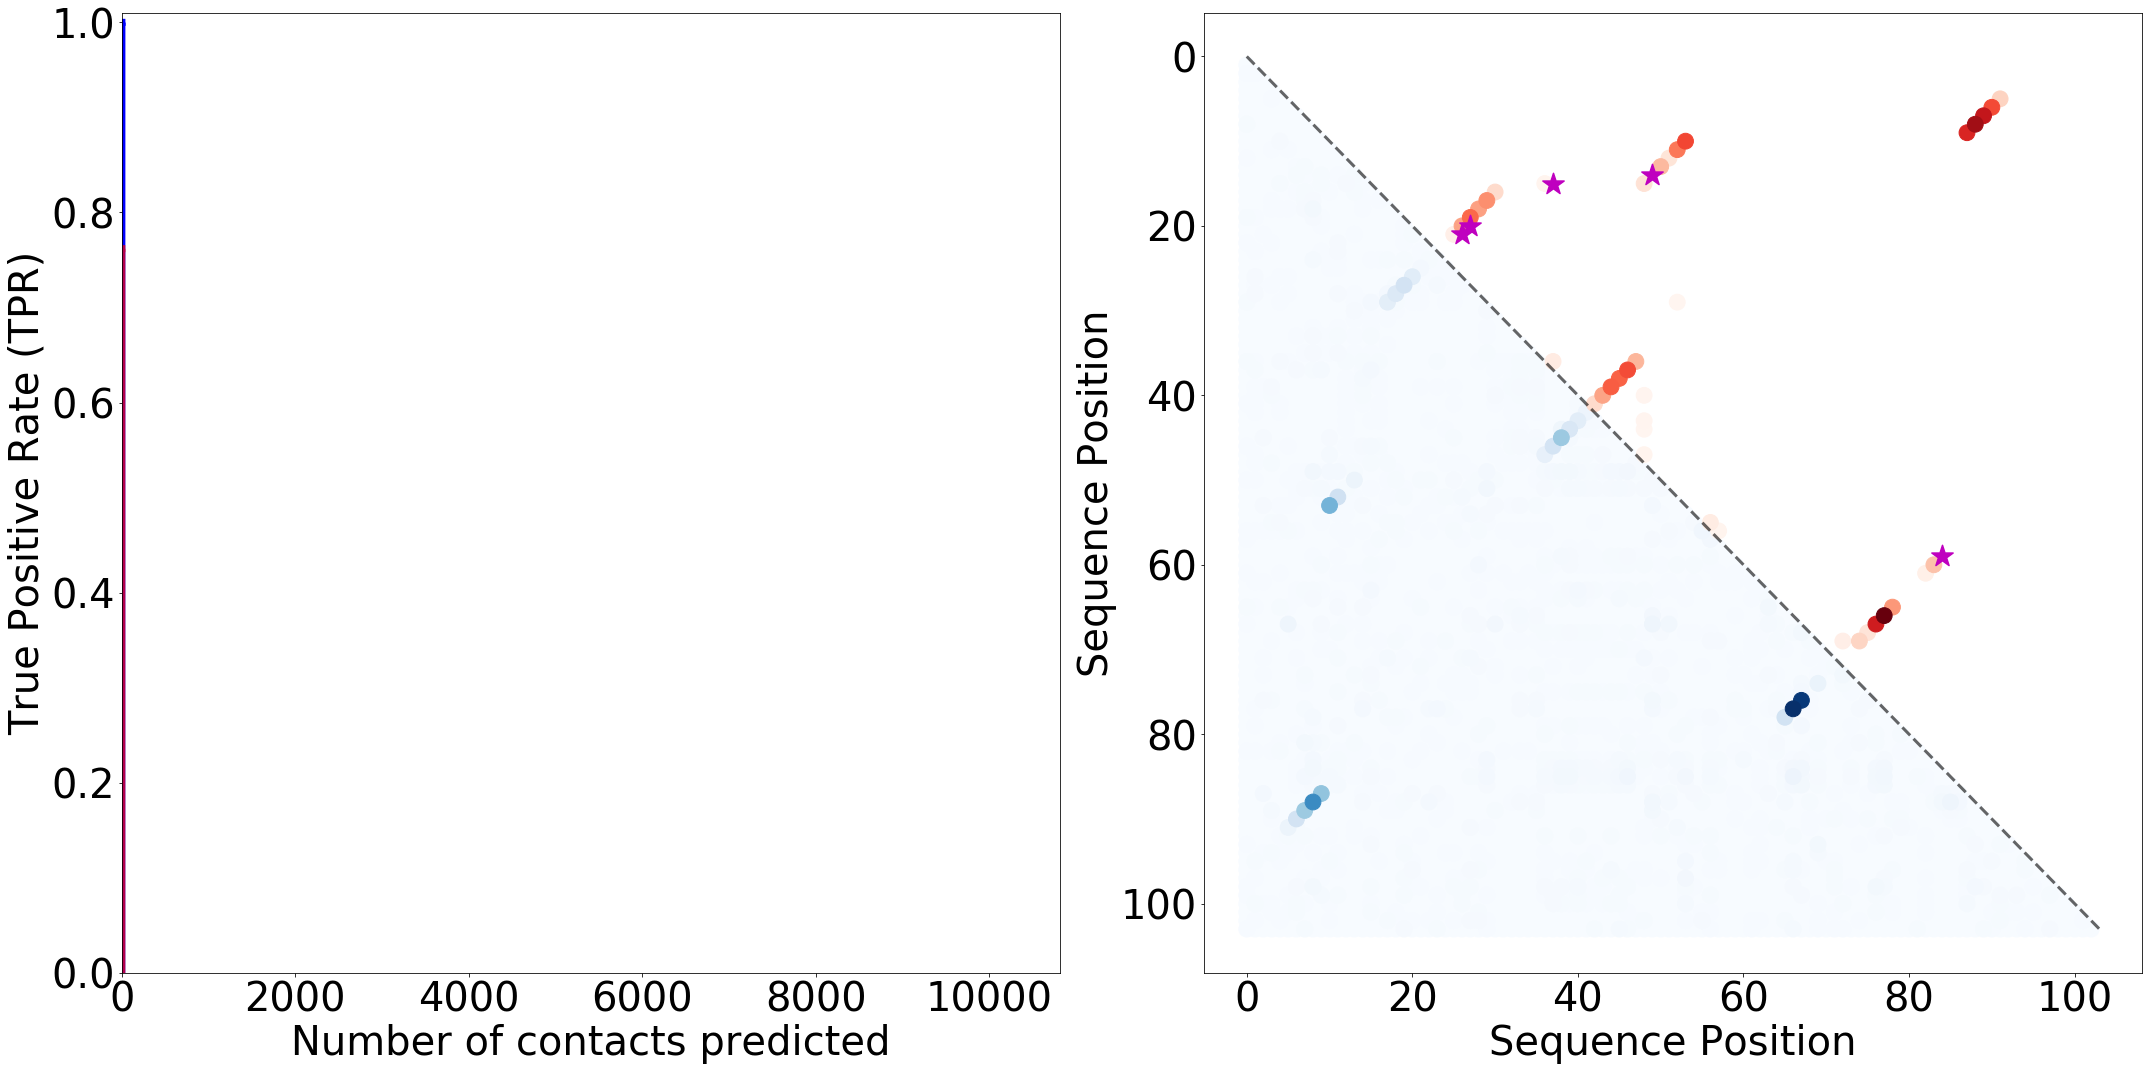

In [8]:
#def compare_EC(fam, comp='cWW_int', min_dist=8.0, ms=100):
numhidden = 512
min_dist=8.0
comp='cWW_int'
ms = 250
for fam in ['RF00059']:
    ######### EXTRACT DATA ###########

    #extract SoM results after an APC correction
    arrayspath = '../../marks/Arrays/%s_mlp_%s_red.npy'%(fam,numhidden)
    hol_mut2 = np.load(arrayspath)
    seqlen,_, dims,_ = hol_mut2.shape
    C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')
    
    #get coordinates for contact plot
    C[np.tril_indices(seqlen)] = np.min(C)
    bp_stretch = np.ravel(C)
    minval = np.sort(bp_stretch)[::-1][-1] #just gets the minimum value - can be changed to a different idx
    bs = np.where(C > minval)
    idx = np.argsort(C[bs])
    x = bs[0][idx] #sorts the x and y coords in order from lowest to highest so highest scores will be plotted last
    y = bs[1][idx]

    score_col = [C[xx,yy] for xx,yy in zip(x,y)] #gets the scores for each coordinate in the needed order

    #Load in the EC annotation
    ECannotfile = '../../marks/%s/%s.EC.interaction.txt'%(fam,fam) 
    EC_df = pd.read_csv(ECannotfile, delimiter='\s+')
    
    #Load in R-scape scores
    ritefile ='%s_rscores.txt'%(fam)
    r_df = pd.read_csv(os.path.join('rscape_scores', ritefile), delim_whitespace=True).iloc[1:, 1:]
    r_df = r_df.apply(pd.to_numeric, errors='ignore')

    ######### QUALITATIVE CONTACTS ###########

    #All cWW annotated interactions
    cWW_int = EC_df[EC_df['interactions'] == 'cWW']
    #All PDB contacts < 8 angstroms
    close_cont = EC_df[EC_df['minimum_atom_distance'] <= min_dist] 
    
    #Get WC annotations not predicted by R-scape
    cWW_coords = [[cWW_int.loc[ii, 'Rfam_reduced_position1'], cWW_int.loc[ii, 'Rfam_reduced_position2']] for ii in cWW_int.index]
    r_coords = [[int(r_df.loc[ii, 'left_pos']-1), int(r_df.loc[ii, 'right_pos']-1)] for ii in r_df.index]

    notinR = np.asarray([WC for WC in cWW_coords if WC not in r_coords])
    

    ######### QUANTITATIVE GRAPHS ###########

    #Get the real positive and negative pdb contacts
    def groundtruth(comp=comp):
        
        if comp == 'cWW_int':
            real_pos = np.zeros((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_pos[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 1.
            real_neg = np.ones((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_neg[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 0.
            real_neg[np.tril_indices(seqlen)] = 0.
        return (real_pos, real_neg)
    
    real_pos, real_neg = groundtruth(comp=comp)
    extent = seqlen**2#len(r_df)#len(cWW_int)*2 #seqlen#
    
    def sumstats(thresh):
        #Get the top thresh SoM scores
        som_pos = bd.plot_wcrank(C, seqlen, thresh)#*2) #because of how we reset C above, we can just use the threshold because both halves of the triangle aren't there.
        som_pos[np.tril_indices(seqlen)] = 0.
        #Get the bottom thresh SoM scores
        som_neg = (~som_pos.astype('bool'))*1 #incantation converts binary to boolean, flips them then back to binary
        som_neg[np.tril_indices(seqlen)] = 0.
        
        TP = np.sum(real_pos*som_pos)
        FP = np.sum(real_neg*som_pos)
        TN = np.sum(real_neg*som_neg)
        FN = np.sum(real_pos*som_neg)

        PPV = TP/(TP+FP)
        FPR = FP/(TN+FP)
        TPR = TP/(TP+FN)

        return (PPV, FPR, TPR, TP, FP, TN, FN)

    def sumstats_r(thresh):
        #Top thresh EC scores
        n_r_P = len(r_df.iloc[:thresh, :])
        r_pos = np.zeros((seqlen,seqlen))
        for ii in range(n_r_P):
            r_pos[int(r_df.iloc[ii, 0]-1), int(r_df.iloc[ii, 1]-1)] = 1.
        r_neg = np.ones((seqlen,seqlen))
        for ii in range(n_r_P):
            r_neg[int(r_df.iloc[ii, 0]-1), int(r_df.iloc[ii, 1]-1)] = 0.

        TP = np.sum(real_pos*r_pos)
        FP = np.sum(real_neg*r_pos)
        TN = np.sum(real_neg*r_neg)
        FN = np.sum(real_pos*r_neg)

        PPV = TP/(TP+FP)
        FPR = FP/(TN+FP)
        TPR = TP/(TP+FN)

        return (PPV, FPR, TPR, TP, FP, TN, FN)
    

    r_ppv = []
    r_tpr = []
    r_fpr = []
    SoM_ppv = []
    SoM_tpr = []
    SoM_fpr = []
    for tr in range(extent):
        rst = sumstats_r(tr)
        somst = sumstats(tr)

        r_ppv.append(rst[0])
        r_tpr.append(rst[2])
        r_fpr.append(rst[1])

        SoM_ppv.append(somst[0])
        SoM_tpr.append(somst[2]) 
        SoM_fpr.append(somst[1])

        
    #get the colour map to select colors for plotting
    pal = 'Blues'
    cmap = mat.cm.get_cmap(pal)


    markersize = ms
    fs = 40
    fig = plt.figure(figsize=(30,15))
    
    #plot the ranked PPV
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(SoM_fpr,SoM_tpr, '-b', label='SoM', linewidth=7., alpha=1.)
    ax1.plot(r_fpr,r_tpr, '-r', label='R-scape scores', linewidth=7., alpha=0.7)
    #ax1.plot(range(extent),SoM_tpr, '-b', label='SoM', linewidth=7., alpha=1.)
    #ax1.plot(range(extent),r_tpr, '-r', label='R-scape scores', linewidth=7., alpha=0.7)
    #ax1.plot(np.ones(len(r_df))*len(r_df), np.linspace(0,1,len(r_df)), 'k--', linewidth=3, alpha=0.6)
    ax1.set_xlabel('Number of contacts predicted', fontsize=fs)
    ax1.set_ylabel('True Positive Rate (TPR)', fontsize=fs)
    #ax1.set_title('cWW interactions predicted', fontsize=fs)
    #ax1.legend(loc='best', fontsize=fs, bbox_to_anchor=(1., 0.75))
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax1.set_ylim([0.,1.01])
    ax1.set_xlim([0.,1.01])
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(x, y, c=score_col, cmap=pal, label = 'SoM', vmin=0., s=markersize) #plot SoM results
    ax2.scatter(r_df.iloc[:,1][::-1] -1, r_df.iloc[:,0][::-1] -1, c=r_df['score'][::-1], cmap='Reds', label = 'R-scape scores', s=markersize)
    ax2.plot(range(seqlen), range(seqlen), 'k--', linewidth=3, alpha=0.6)
    ax2.scatter(notinR[:, 1], notinR[:,0], edgecolors='m',
            label= 'WC annotation', facecolors='m', marker='*',s=markersize*2, linewidth=1.5)
#notinR[:, 1], notinR[:,0]
    #ax2.scatter(cWW_int.iloc[:,2], cWW_int.iloc[:,1], label = 'cWW',
     #           edgecolors='k',  marker='o', facecolors='none', linewidths=0.75, s=markersize, alpha=0.75)
    #ax2.scatter(cWW_int.iloc[:,1], cWW_int.iloc[:,2],
    #            edgecolors='k',  marker='x', facecolors='k', linewidths=1.5, s=markersize, alpha=0.5)
    
    #ax2.set_title('%s: SoM vs. EC '%(fam), fontsize=fs)
    #ax2.legend(loc='best', fontsize=fs, bbox_to_anchor=(1., 0.5))
    ax2.set_xlabel('Sequence Position', fontsize=fs)
    ax2.set_ylabel('Sequence Position', fontsize=fs)
    ax2.invert_yaxis()
    ax2.set_facecolor('w')#(cmap(0.))
    ax2.tick_params(axis='both', which='major', labelsize=fs)

    #plt.savefig('%s/%s_tpr_rscape_mitWC.png'%(folder,fam))
    #plt.savefig('%s/%s_tpr_rscape_mitWC.pdf'%(folder,fam))
    #plt.savefig('all_plots/pdfs/%s_tpr_rscape_mitWC.pdf'%(fam))
    #plt.savefig('all_plots/pngs/%s_tpr_rscape_mitWC.png'%(fam))
    plt.show()
    plt.close()
    
    #return (SoM_tpr, SoM_fpr)

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


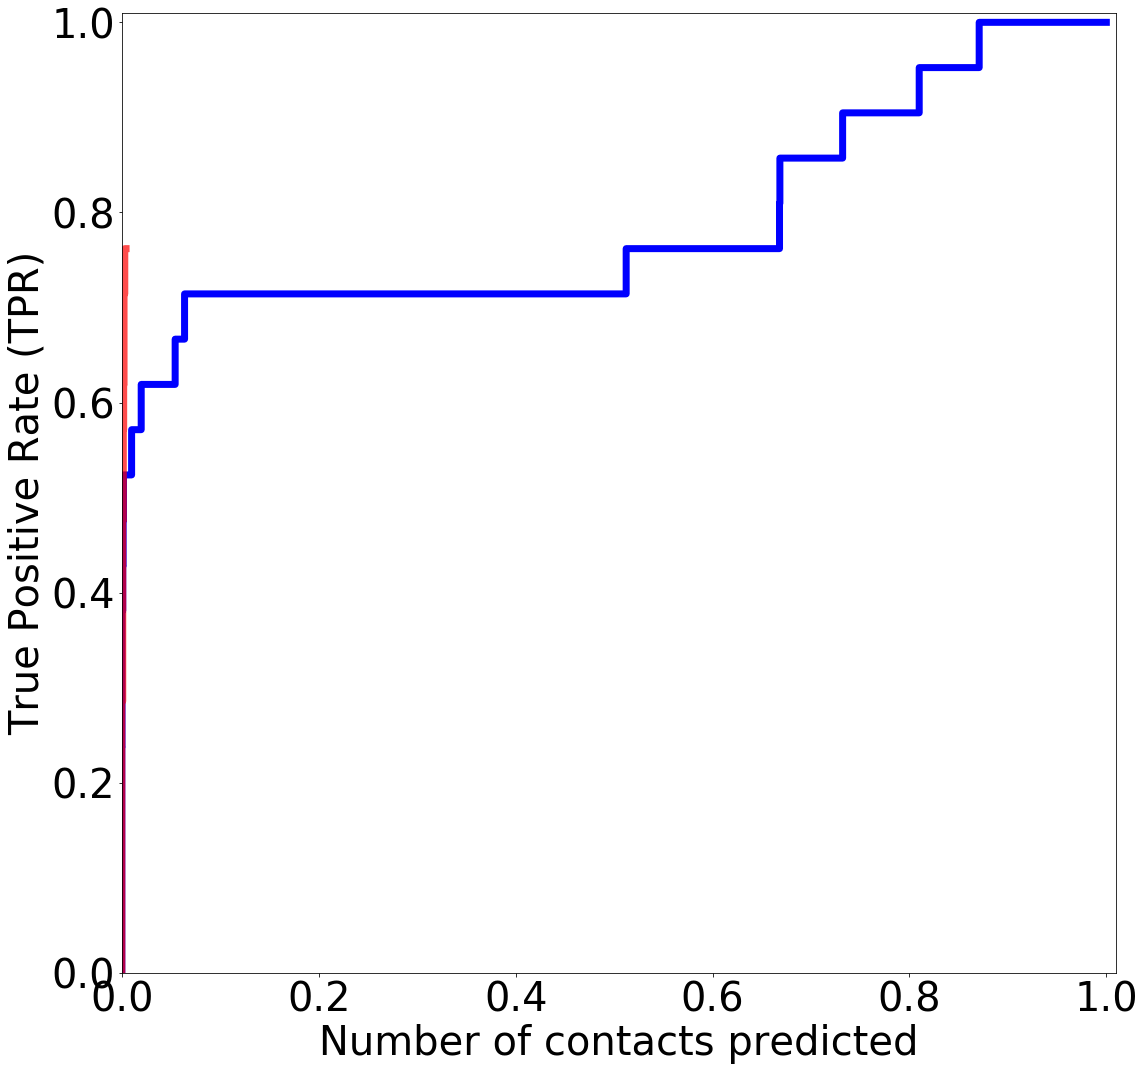

In [11]:
fig = plt.figure(figsize=(30,15))

#plot the ranked PPV
ax1 = fig.add_subplot(1,2,1)
ax1.plot(SoM_fpr,SoM_tpr, '-b', label='SoM', linewidth=7., alpha=1.)
ax1.plot(r_fpr,r_tpr, '-r', label='R-scape scores', linewidth=7., alpha=0.7)
#ax1.plot(range(extent),SoM_tpr, '-b', label='SoM', linewidth=7., alpha=1.)
#ax1.plot(range(extent),r_tpr, '-r', label='R-scape scores', linewidth=7., alpha=0.7)
#ax1.plot(np.ones(len(r_df))*len(r_df), np.linspace(0,1,len(r_df)), 'k--', linewidth=3, alpha=0.6)
ax1.set_xlabel('Number of contacts predicted', fontsize=fs)
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=fs)
#ax1.set_title('cWW interactions predicted', fontsize=fs)
#ax1.legend(loc='best', fontsize=fs, bbox_to_anchor=(1., 0.75))
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_ylim([0.,1.01])
ax1.set_xlim([0.,1.01])
plt.show()

In [7]:
sumstats(seqlen*seqlen)

(0.00392083644510829, 1.0, 1.0, 21.0, 5335.0, 0.0, 0.0)

In [3]:
folder = 'tpr.mitWC'
if not os.path.isdir(folder):
    os.mkdir(folder)

In [9]:
# RF00010 - lw: 0.75, a: 0.5, markersize: 250
# RF00023 - lw: 0.75, a: 0.75, markersize: 150
# RF00005 - lw: 3.0, a: 1.0, markersize: 250
# RF00059 - lw:1.5, a: 0.85, markersize: 250
families = ['RF00002', 'RF00005', 'RF00010', 'RF00017', 'RF00023', 'RF00050',
            'RF00059', 'RF00162', 'RF00167', 'RF00169', 'RF00174', 'RF00234',
            'RF00380', 'RF00504', 'RF01734', 'RF01786', 'RF01831', 'RF01852', 'RF02001']#, 'RF01960']

numhidden = 512
for fam in families:
    if fam not in ['RF00005', 'RF00010', 'RF00023', 'RF00504']:
        compare_EC(fam, ms=250)

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


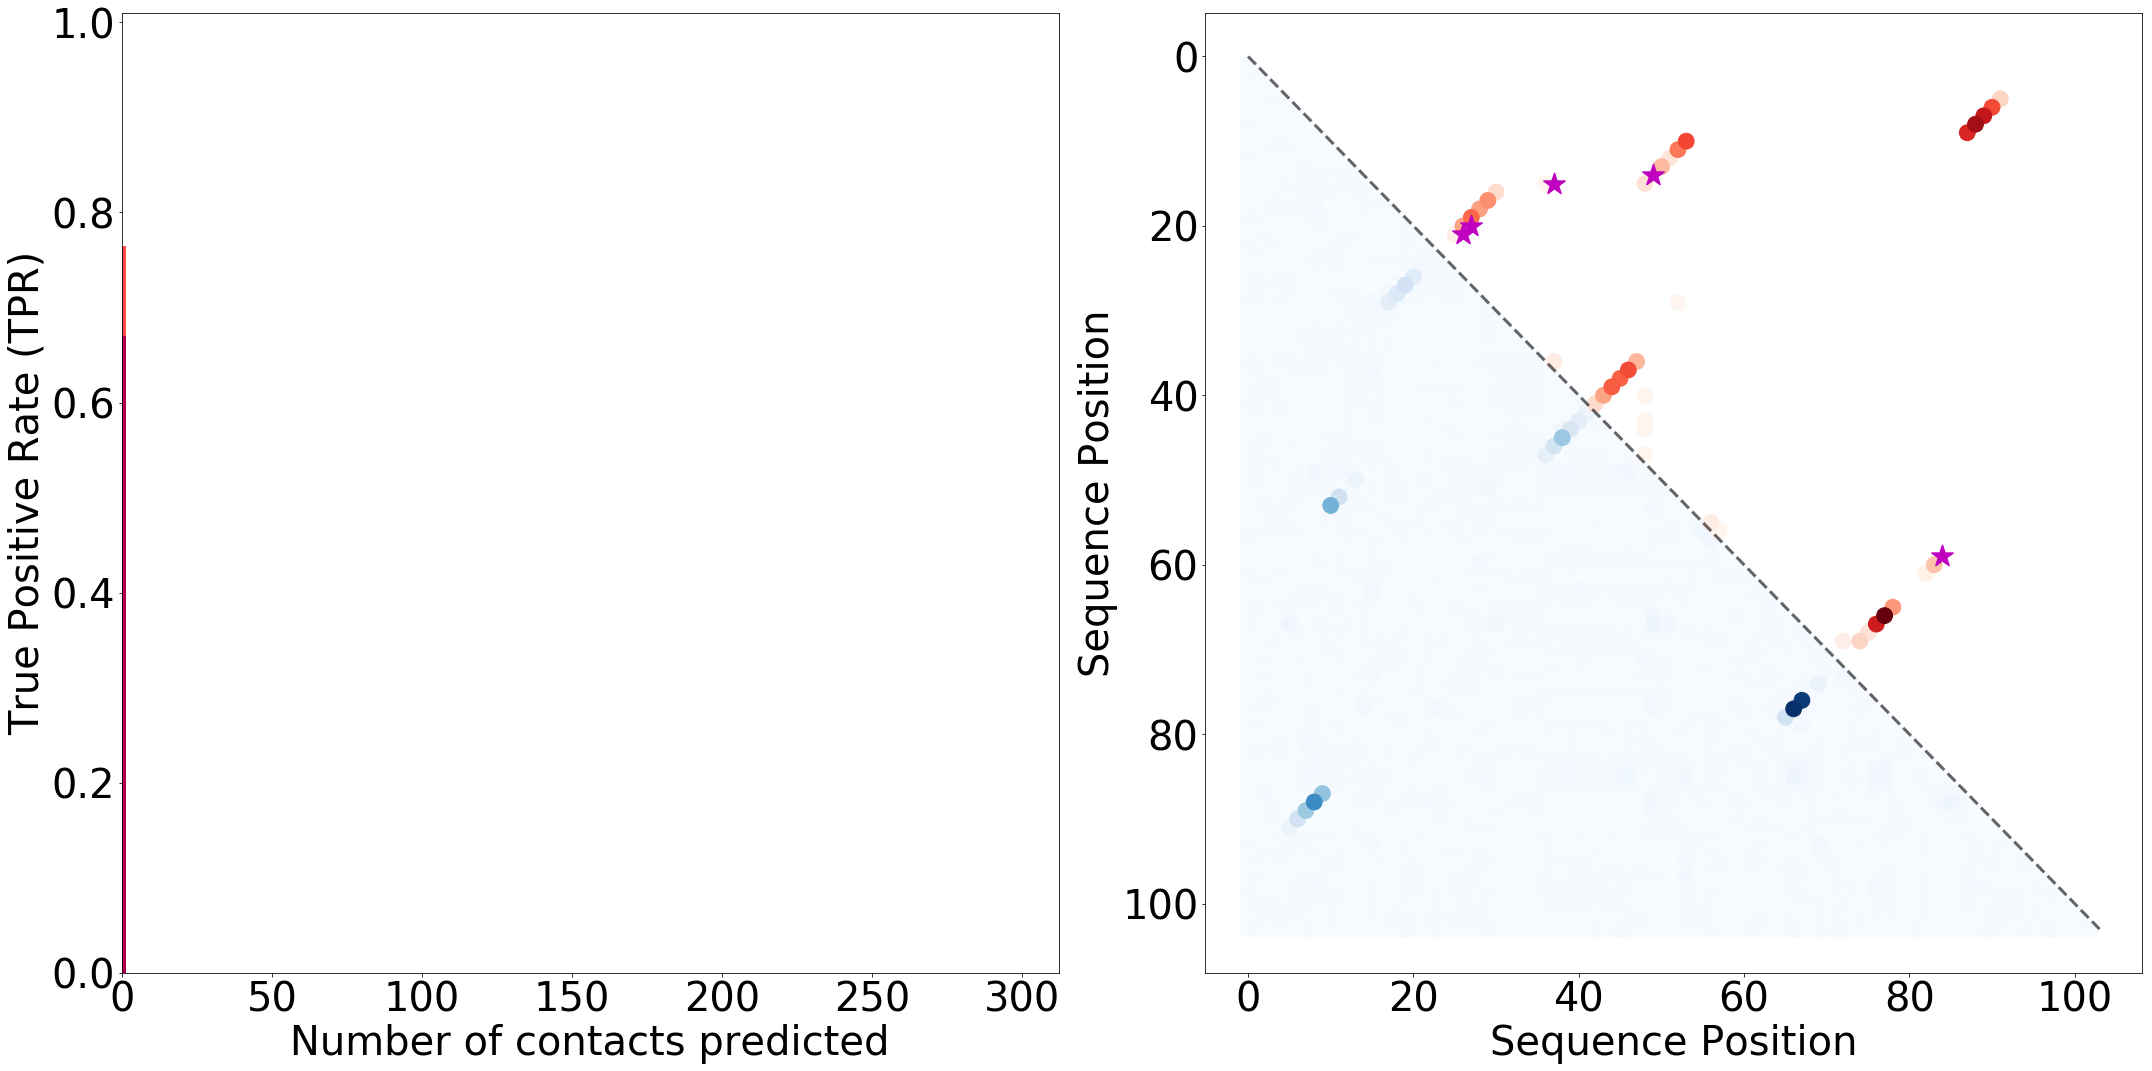

([0.0,
  0.047619047619047616,
  0.09523809523809523,
  0.14285714285714285,
  0.19047619047619047,
  0.23809523809523808,
  0.23809523809523808,
  0.2857142857142857,
  0.3333333333333333,
  0.38095238095238093,
  0.38095238095238093,
  0.38095238095238093,
  0.38095238095238093,
  0.38095238095238093,
  0.42857142857142855,
  0.42857142857142855,
  0.42857142857142855,
  0.47619047619047616,
  0.47619047619047616,
  0.47619047619047616,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.5238095238095238,
  0.523

In [12]:
numhidden = 512
compare_EC('RF00059', ms=250)

In [ ]:
cykfile = '../../../data_marks/%s/%s_red.cyk.sto'%(fam,fam)
SS = ''
with open(cykfile, 'r') as f1:
    for line in f1:
        if line[:13] == '#=GC SS_cons ':
            line = line.split()
            SS = SS + line[2]
            
nest_coords = bd.bp_coords(SS)
nest_coords = nest_coords[:len(nest_coords)//2]

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


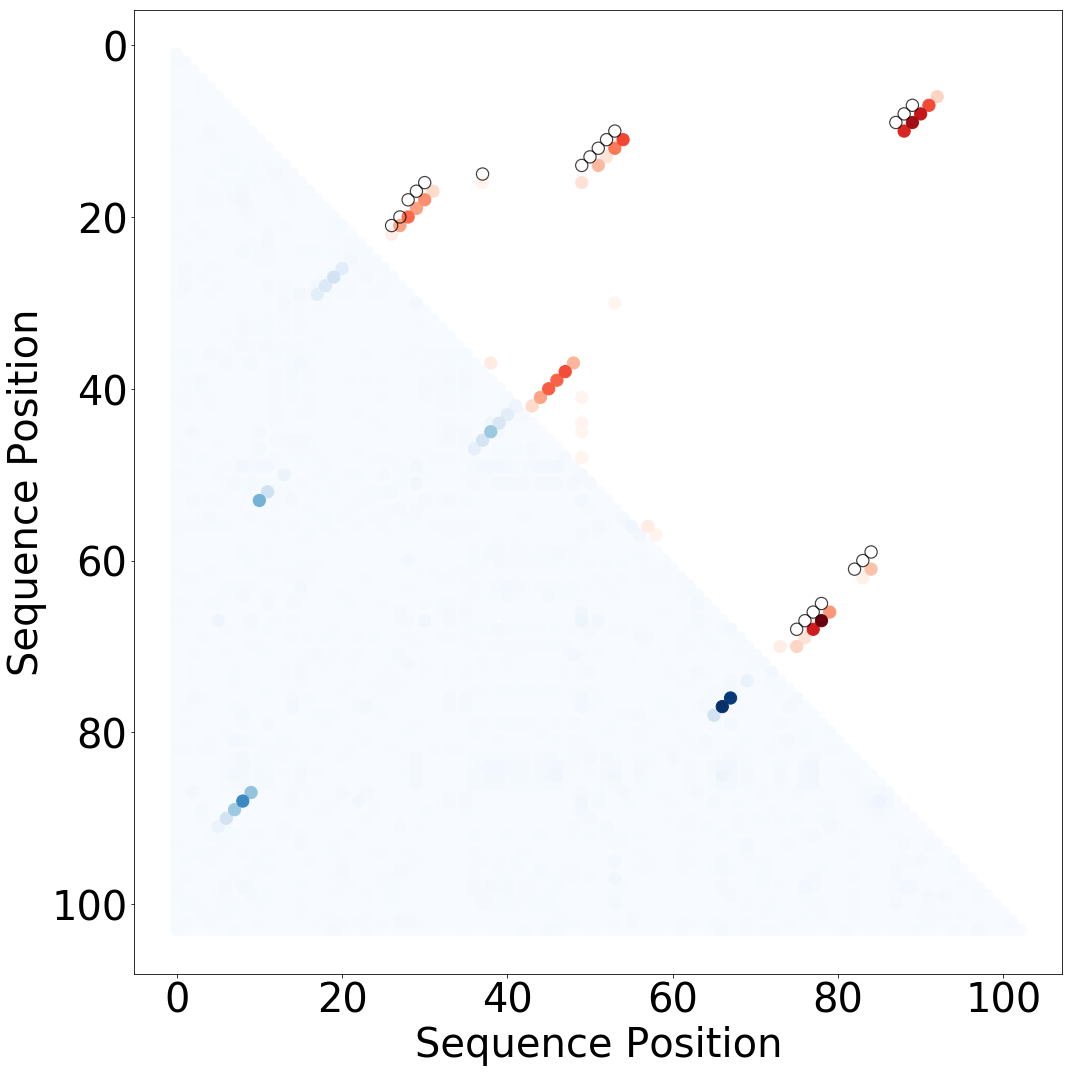

In [50]:
fig = plt.figure(figsize=(15,15))

ax2 = fig.add_subplot(1,1,1)
ax2.scatter(x, y, c=score_col, cmap=pal, label = 'SoM', vmin=0., s=markersize) #plot SoM results
ax2.scatter(r_df.iloc[:,1][::-1], r_df.iloc[:,0][::-1], c=r_df['score'][::-1], cmap='Reds', label = 'R-scape scores', s=markersize)

ax2.scatter(cWW_int.iloc[:,2], cWW_int.iloc[:,1], label = 'cWW',
            edgecolors='k',  marker='o', facecolors='none', linewidths=1.2, s=markersize, alpha=0.75)
#ax2.scatter(cWW_int.iloc[:,1], cWW_int.iloc[:,2],
#            edgecolors='k',  marker='x', facecolors='k', linewidths=1.5, s=markersize, alpha=0.5)

#ax2.set_title('%s: SoM vs. EC '%(fam), fontsize=fs)
#ax2.legend(labels=['SoM', 'EC', 'cWW'], loc='best', fontsize=fs, bbox_to_anchor=(1., 0.5))
ax2.set_xlabel('Sequence Position', fontsize=fs)
ax2.set_ylabel('Sequence Position', fontsize=fs)
ax2.invert_yaxis()
ax2.set_facecolor('w')#(cmap(0.))
ax2.tick_params(axis='both', which='major', labelsize=fs)

#plt.savefig('%s_compEC.png'%(fam))
plt.show()
plt.close()

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


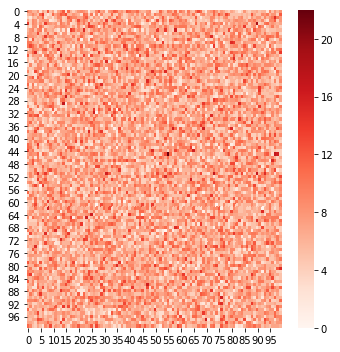

In [121]:
plt.figure(figsize=(5,5))
sb.heatmap(np.random.poisson(lam=7, size=(100,100)),cmap='Reds', cbar=True)
plt.savefig('Redcolorbar.pdf')
plt.show()